In [1]:
import multiprocessing as mp
import os
import numpy as np
import pandas as pd
import configparser
import matplotlib.pyplot as plt
import seaborn as sns
import torch_tensorrt

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torchvision import datasets, models
from torchvision.transforms import ToTensor, transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch_tensorrt import compile as tx_compile

from glob import glob
from PIL import Image
from tqdm import tqdm

print(torch_tensorrt.__version__)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = '1'

1.4.0


In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = glob(img_dir + "/*.jpg")
        self.transform = transform

    def __len__(self):
        return len(self.img_dir)

    def __getitem__(self, idx):
        image = Image.open(self.img_dir[idx])
        if self.transform:
            image = self.transform(image)

        return image

In [3]:
config = configparser.ConfigParser()
config.read('./config/config.ini')
model_name = "model_ch3_bottom2"

transform = transforms.Compose([
    transforms.Resize(eval(dict(config[model_name])["transforms"])["resize"], interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=eval(dict(config[model_name])["transforms"])["normalize"][0],
                         std=eval(dict(config[model_name])["transforms"])["normalize"][1]),
])

In [4]:
test_data = CustomImageDataset("./img", transform=transform)

In [5]:
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [6]:
idx_to_cls = eval(dict(config[model_name])["idx_to_cls"])
num_classes = int(dict(config[model_name])["num_classes"])

model = models.efficientnet_v2_l(weights=None)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
check_point = torch.load("./model_ch3_bottom2.pth")

for key in list(check_point.keys()):
    if "module." in key:
        check_point[key.replace("module.", "")] = check_point[key]
        del check_point[key]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(check_point)
model.to(device)
model.eval()

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
torch_timings=np.zeros((len(test_dataloader), 1))
torch_list = []

with torch.no_grad():
    with tqdm(test_dataloader, ncols=160, ascii=" =", unit="batch") as tepoch:
        for i, inputs in enumerate(tepoch):
            starter.record()
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_prob, predicted = torch.max(probabilities, 1)
            torch_list.extend(predicted)
            ender.record()
            # WAIT FOR GPU SYNC
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            torch_timings[i] = curr_time

100%|======================================================================================================================| 522/522 [06:53<00:00,  1.26batch/s]


In [7]:
compile_settings = {
    "inputs": [torch_tensorrt.Input(
        min_shape=[1, 3, 480, 480],
        opt_shape=[32, 3, 480, 480],
        max_shape=[64, 3, 480, 480],
        # For static size shape=[1, 3, 224, 224]
        dtype=torch.half, # Datatype of input tensor. Allowed options torch.(float|half|int8|int32|bool)
    )],
    "enabled_precisions": {torch.half}, # Run with FP16
}

trt_ts_module = tx_compile(model, **compile_settings)

tensorrt_list = []

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
tensorrt_timings=np.zeros((len(test_dataloader), 1))

print("run")

with torch.no_grad():
    with tqdm(test_dataloader, ncols=160, ascii=" =", unit="batch") as tepoch:
        for i, inputs in enumerate(tepoch):
            starter.record()
            inputs = inputs.to(device).half()
            outputs = trt_ts_module(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_prob, predicted = torch.max(probabilities, 1)
            tensorrt_list.extend(predicted)
            ender.record()
            # WAIT FOR GPU SYNC
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            tensorrt_timings[i] = curr_time

The compiler is going to use the user setting Half
This conflict may cause an error at runtime due to partial compilation being enabled and therefore
compatibility with PyTorch's data type convention is required.
If you do indeed see errors at runtime either:
- Remove the dtype spec for x.1
- Disable partial compilation by setting require_full_compilation to True


run


100%|======================================================================================================================| 522/522 [01:42<00:00,  5.08batch/s]


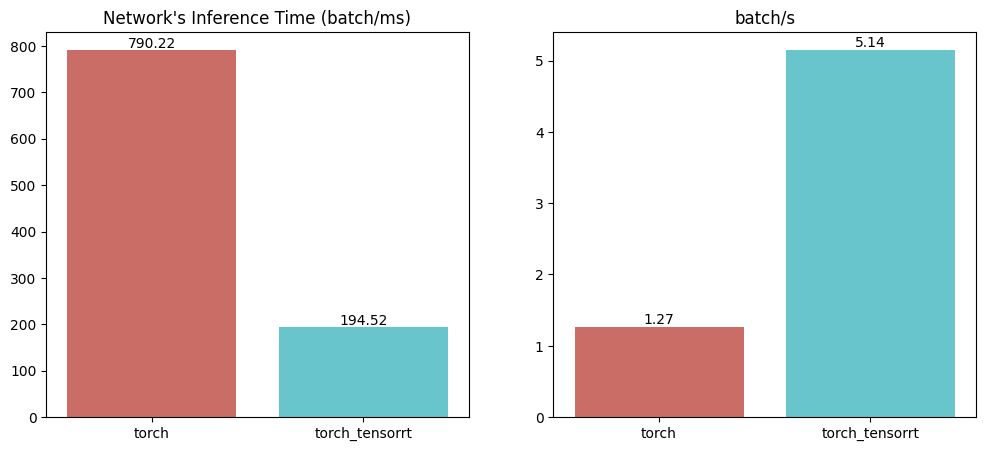

In [51]:
networks = ['torch', 'torch_tensorrt']
values = [np.round(np.mean(torch_timings), 3), np.round(np.mean(tensorrt_timings), 3)]
values2 = [(1000 / np.round(np.mean(torch_timings), 3)), (1000 / np.round(np.mean(tensorrt_timings), 3))]
colors = sns.color_palette('hls',len(values))

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("Network's Inference Time (batch/ms)")
ax = sns.barplot(x=networks, y=values, hue=networks, palette=colors)

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로 위치
            p.get_y() + p.get_height() + 5,   # 세로 위치
            f"{p.get_height():.2f}",     # 값 + 표시방법 소수 둘째자리까지 
            ha = 'center' )   # 좌우정렬 중간으로

plt.subplot(122)
plt.title("batch/s")
ax2 = sns.barplot(x=networks, y=values2, hue=networks, palette=colors)

for p in ax2.patches:
    ax2.text(p.get_x() + (p.get_width()/2) ,   # 가로 위치
            p.get_y() + p.get_height() + 0.05,   # 세로 위치
            f"{p.get_height():.2f}",     # 값 + 표시방법 소수 둘째자리까지 
            ha = 'center' )   # 좌우정렬 중간으로

plt.show()

In [8]:
(torch.tensor(torch_list) != torch.tensor(tensorrt_list)).sum()

tensor(0)

In [9]:
# 두 출력 간의 유사성 확인
if torch.allclose(torch.tensor(torch_list), torch.tensor(tensorrt_list), atol=1e-3):
    print("PyTorch와 TensorRT 모델의 출력이 유사합니다.")
else:
    print("PyTorch와 TensorRT 모델의 출력이 다릅니다.")

PyTorch와 TensorRT 모델의 출력이 유사합니다.
